# Imports

In [6]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
from keras.utils import np_utils
import GPyOpt
from sklearn.model_selection import ParameterSampler

2023-02-23 13:38:57.813065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [9]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print(train_X[1].shape)
#plt.imshow(train_X[1], cmap = "Greys")
#plt.show()

# one-out-of-k encoding of the labels
# using keras' numpy-related utilities
n_classes = 10
print("Shape (train) before one-hot encoding: ", train_y.shape)
Y_train = np_utils.to_categorical(train_y, n_classes)
Y_test = np_utils.to_categorical(test_y, n_classes)
print("Shape (train) after one-hot encoding: ", Y_train.shape)

(28, 28)
Shape (train) before one-hot encoding:  (60000,)
Shape (train) after one-hot encoding:  (60000, 10)


# CNN Model

In [3]:
CNN = ks.models.Sequential()
# convolutional layer
CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
# flatten output of conv
CNN.add(ks.layers.Flatten())
# hidden layer
CNN.add(ks.layers.Dense(100, activation='relu'))
# output layer
CNN.add(ks.layers.Dense(10, activation='softmax'))

CNN.summary()

CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

CNN.fit(train_X, Y_train, batch_size = 32)

acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
print(acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 25)        250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 25)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4225)              0         
                                                                 
 dense (Dense)               (None, 100)               422600    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 423,860
Trainable params: 423,860
Non-trainable params: 0
__________________________________________________

2023-02-19 16:44:06.239406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 [==============================] - 1s 2ms/step - loss: 0.1033 - accuracy: 0.9686
0.9685999751091003


# Bayesian Optimization

In [15]:
## define the domain of the considered parameters
n_nodes = tuple(np.arange(1,101,1, dtype= np.int)) # number of nodes of second-last layer (1-100)
batch_size = tuple(np.arange(1,101,1, dtype= np.int)) # batch_size (1-100)

# define the dictionary for GPyOpt
domain = [
    {"name": "n_nodes", "type": "discrete", "domain": n_nodes},
    {"name": "batch_size", "type": "discrete", "domain": batch_size},
]

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(parameters): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = parameters[0]
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(int(param[0]), activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    CNN.fit(train_X, Y_train, batch_size = int(param[1]))
    acc = CNN.evaluate(test_X, Y_test, batch_size = int(param[1]))[1]
    print(acc)  
    return - acc # because GPyOpt minimizes everything


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 15) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_nodes=" + str(x_best[0]) + ", batch_size=" + str(x_best[1]))
print(opt.Y.shape)

127/127 [==============================] - 1s 3ms/step - loss: 0.2007 - accuracy: 0.9470
0.9470000267028809
182/182 [==============================] - 0s 2ms/step - loss: 0.4668 - accuracy: 0.8961
0.8960999846458435
257/257 [==============================] - 1s 2ms/step - loss: 0.1155 - accuracy: 0.9689
0.9689000248908997
129/129 [==============================] - 0s 3ms/step - loss: 2.3010 - accuracy: 0.1135
0.11349999904632568
770/770 [==============================] - 1s 1ms/step - loss: 0.0871 - accuracy: 0.9737
0.9736999869346619
257/257 [==============================] - 1s 2ms/step - loss: 0.1278 - accuracy: 0.9639
0.9639000296592712
334/334 [==============================] - 1s 2ms/step - loss: 0.1379 - accuracy: 0.9581
0.9581000208854675
10000/10000 [==============================] - 5s 530us/step - loss: 2.3019 - accuracy: 0.1135
0.11349999904632568
200/200 [==============================] - 1s 3ms/step - loss: 0.1102 - accuracy: 0.9705
0.9704999923706055
10000/10000 [=======

# Random Search

In [13]:
import time 

# hyperparams dictionary 

domain = {"n_nodes": n_nodes,
        "batch_size": batch_size}

# create the ParameterSampler
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list')
print(param_list)
#rounded_list = [dict((k,v) for (k, v) in d.items()) for d in param_list]

#print('Random parameters we are going to consider')
#print(rounded_list)

## now we can train the random forest using these parameters tuple, and for
## each iteration we store the best value of the oob

current_best_acc = 0
iteration_best_acc = 0 
max_acc_per_iteration = []
i = 0
for params in param_list:
    print(i)
    print(params)
    
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(params["n_nodes"], activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    CNN.fit(train_X, Y_train, batch_size = params["batch_size"])
    end = time.time()
    acc = CNN.evaluate(test_X, Y_test, batch_size = params["batch_size"])[1]
    print('Accuracy found:', acc)
    if acc > current_best_acc:
        current_best_acc = acc
        iteration_best_acc = i
    
    max_acc_per_iteration.append(current_best_acc)
    i += 1
    print(f'It took {end - start} seconds')
    

Param list
[{'n_nodes': 72, 'batch_size': 98}, {'n_nodes': 27, 'batch_size': 96}, {'n_nodes': 31, 'batch_size': 41}, {'n_nodes': 72, 'batch_size': 76}, {'n_nodes': 45, 'batch_size': 85}, {'n_nodes': 44, 'batch_size': 32}, {'n_nodes': 7, 'batch_size': 47}, {'n_nodes': 46, 'batch_size': 68}, {'n_nodes': 44, 'batch_size': 39}, {'n_nodes': 51, 'batch_size': 95}, {'n_nodes': 2, 'batch_size': 83}, {'n_nodes': 25, 'batch_size': 52}, {'n_nodes': 20, 'batch_size': 79}, {'n_nodes': 76, 'batch_size': 95}, {'n_nodes': 43, 'batch_size': 15}, {'n_nodes': 28, 'batch_size': 83}, {'n_nodes': 71, 'batch_size': 98}, {'n_nodes': 43, 'batch_size': 89}, {'n_nodes': 5, 'batch_size': 21}, {'n_nodes': 7, 'batch_size': 36}]
0
{'n_nodes': 72, 'batch_size': 98}
103/103 [==============================] - 0s 3ms/step - loss: 0.1892 - accuracy: 0.9511
Accuracy found: 0.9510999917984009
It took 5.170936107635498 seconds
1
{'n_nodes': 27, 'batch_size': 96}
105/105 [==============================] - 0s 3ms/step - loss:

# Comparison

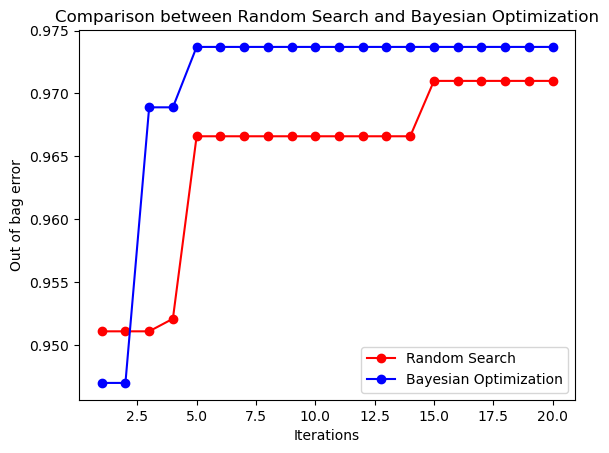

In [16]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO, note that it is also provided by GPOpt in Y_Best
y_bo = np.maximum.accumulate(-opt.Y).ravel()
# define iteration number
xs = np.arange(1,21,1)
xp = np.arange(1,y_bo.shape[0] + 1,1)

plt.plot(xs, max_acc_per_iteration, 'o-', color = 'red', label='Random Search')
plt.plot(xp, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Out of bag error')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

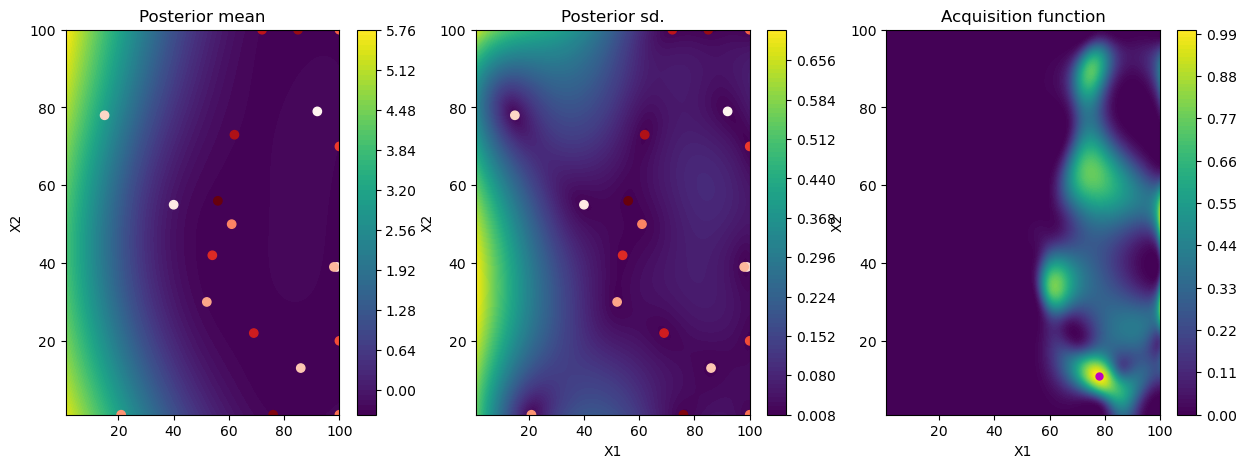

In [17]:
opt.plot_acquisition() #Virker først med 2D

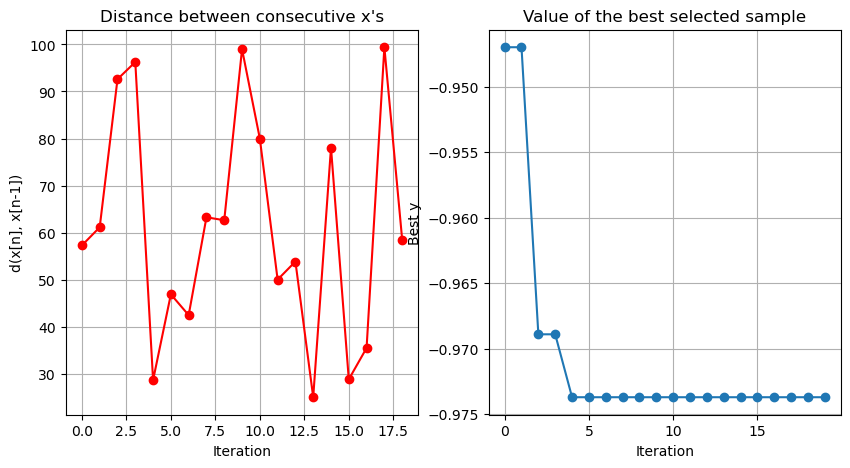

'We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample.'

In [18]:
opt.plot_convergence() #Convergence
"""We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample."""

In [19]:
def objective_function(parameters): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = parameters[0]
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(int(param[0]), activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    CNN.fit(train_X, Y_train, batch_size = int(param[1]))
    acc = CNN.evaluate(test_X, Y_test, batch_size = int(param[1]))[1]
    print(acc)  
    return - acc # because GPyOpt minimizes everything


In [68]:
n_runs = 5
max_iteration = 10
## define the domain of the considered parameters
n_nodes = tuple(np.arange(1,101,1, dtype= np.int)) # number of nodes of second-last layer (1-100)
batch_size = tuple(np.arange(1,101,1, dtype= np.int)) # batch_size (1-100)


domain_bo = [
    {"name": "n_nodes", "type": "discrete", "domain": n_nodes},
    {"name": "batch_size", "type": "discrete", "domain": batch_size},
]

domain_rs = {"n_nodes": n_nodes,
        "batch_size": batch_size}


acc_bo = []
x_bo = []

acc_rs = []
x_rs = []


for _ in range(n_runs):
    
    # Bayesian Optimization
    opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain_bo,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
    opt.acquisition.exploration_weight=0.5

    opt.run_optimization(max_iter = max_iteration, eps=0) 

    x_best = opt.X[np.argmin(opt.Y)]
    print("The best parameters obtained: n_nodes=" + str(x_best[0]) + ", batch_size=" + str(x_best[1]))
    y_bo = np.maximum.accumulate(-opt.Y).ravel()
    acc_bo.append(y_bo.tolist())
    x_bo.append(x_best)

    # Random Search
    # create the ParameterSampler
    param_list = list(ParameterSampler(domain_rs, n_iter=y_bo.shape[0], random_state=32))
    print('Param list')
    print(param_list)

    current_best_acc = 0
    iteration_best_acc = 0 
    max_acc_per_iteration = []
    best_param = 0
    i = 0
    for params in param_list:
        print(i)
        print(params)
        
        #fit the model
        CNN = ks.models.Sequential()
        # convolutional layer
        CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
        CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
        # flatten output of conv
        CNN.add(ks.layers.Flatten())
        # hidden layer
        CNN.add(ks.layers.Dense(params["n_nodes"], activation='relu'))
        # output layer
        CNN.add(ks.layers.Dense(10, activation='softmax'))

        CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

        start = time.time()
        CNN.fit(train_X, Y_train, batch_size = params["batch_size"])
        end = time.time()
        acc = CNN.evaluate(test_X, Y_test, batch_size = params["batch_size"])[1]
        print('Accuracy found:', acc)
        if acc > current_best_acc:
            current_best_acc = acc
            best_param = params
            iteration_best_acc = i
        
        max_acc_per_iteration.append(current_best_acc)

        i += 1
    acc_rs.append(max_acc_per_iteration)
    x_rs.append(param_list)



106/106 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9451
0.9451000094413757
104/104 [==============================] - 0s 3ms/step - loss: 0.2301 - accuracy: 0.9474
0.9473999738693237
186/186 [==============================] - 1s 2ms/step - loss: 0.1615 - accuracy: 0.9588
0.9588000178337097
186/186 [==============================] - 1s 2ms/step - loss: 0.1570 - accuracy: 0.9570
0.9570000171661377
197/197 [==============================] - 1s 2ms/step - loss: 0.3025 - accuracy: 0.9457
0.9456999897956848
182/182 [==============================] - 1s 2ms/step - loss: 0.1062 - accuracy: 0.9703
0.970300018787384
179/179 [==============================] - 1s 2ms/step - loss: 0.1245 - accuracy: 0.9667
0.96670001745224
182/182 [==============================] - 1s 2ms/step - loss: 0.1691 - accuracy: 0.9586
0.9585999846458435
179/179 [==============================] - 1s 2ms/step - loss: 0.1453 - accuracy: 0.9616
0.9616000056266785
176/176 [======================

In [69]:
print(acc_bo)
print(acc_rs)
print(len(acc_bo[1]))


[[0.9451000094413757, 0.9473999738693237, 0.9588000178337097, 0.9588000178337097, 0.9588000178337097, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384, 0.970300018787384], [0.11349999904632568, 0.9664000272750854, 0.9664000272750854, 0.9664000272750854, 0.9664000272750854, 0.9664000272750854, 0.9664000272750854, 0.9664000272750854, 0.9664000272750854, 0.9674000144004822, 0.9674000144004822, 0.9681000113487244, 0.9681000113487244, 0.9681000113487244, 0.9681000113487244], [0.9700999855995178, 0.9700999855995178, 0.9700999855995178, 0.9700999855995178, 0.9700999855995178, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015, 0.9718000292778015], [0.9690999984741211, 0.9690999984741211, 0.9690999984741211, 0.9690999984741211, 0.9690999984741211, 0

In [70]:
print(data_dict)

{'Iteration': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'BO_Run': [0.9555000066757202, 0.9577999711036682, 0.9645000100135803, 0.9645000100135803, 0.9645000100135803, 0.9731000065803528, 0.9731000065803528, 0.9731000065803528, 0.9731000065803528, 0.9731000065803528, 0.9641000032424927, 0.9642000198364258, 0.9642000198364258, 0.9642000198364258, 0.9642000198364258, 0.9642000198364258, 0.9642000198364258, 0.965399980545044, 0.9710999727249146, 0.9710999727249146], 'RS_Run': [0.960099995136261, 0.960099995136261, 0.960099995136261, 0.9639999866485596, 0.9639999866485596, 0.9700999855995178, 0.9700999855995178, 0.9700999855995178, 0.9700999855995178, 0.9700999855995178, 0.9563000202178955, 0.9563000202178955, 0.9575999975204468, 0.9575999975204468, 0.9575999975204468, 0.965399980545044, 0.965399980545044, 0.965399980545044, 0.965399980545044, 0.965399980545044]}


In [91]:
import seaborn as sns
import pandas as pd

data_dict = {"Iteration": [], "BO_Run": [], "RS_Run": []}

for i in range(n_runs):
    for j in range(max_iteration + 5):
        #if acc_bo[i][j] > 0.9:
            data_dict["BO_Run"].append(acc_bo[i][j])
            data_dict["RS_Run"].append(acc_rs[i][j])
            data_dict["Iteration"].append(j+1)

data = pd.DataFrame(data_dict)
print(data)


    Iteration  BO_Run  RS_Run
0           1  0.9451  0.9570
1           2  0.9474  0.9570
2           3  0.9588  0.9570
3           4  0.9588  0.9624
4           5  0.9588  0.9624
..        ...     ...     ...
70         11  0.9708  0.9682
71         12  0.9708  0.9682
72         13  0.9708  0.9682
73         14  0.9708  0.9682
74         15  0.9708  0.9699

[75 rows x 3 columns]


In [88]:
data["logBO"] = np.log(data["BO_Run"])
data["logRS"] = np.log(data["RS_Run"])

(0.95, 0.973)

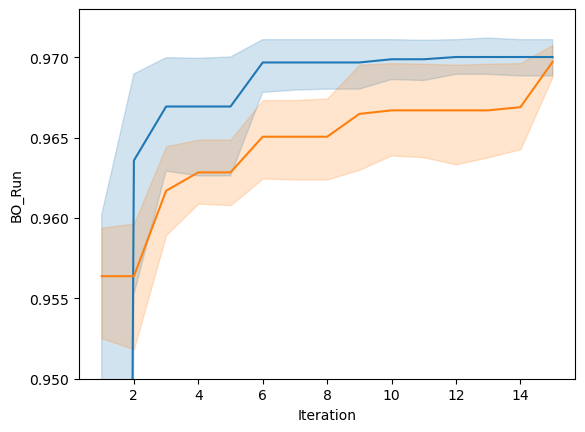

In [92]:
sns.lineplot(data=data, x="Iteration", y="BO_Run")
sns.lineplot(data=data, x="Iteration", y="RS_Run")
plt.ylim(0.95,0.973)